In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Carregando os dados e ajustando o datetime
tsla_data = pd.read_csv("data/TSLA.csv")
tsla_data["Date"] = pd.to_datetime(tsla_data["Date"])
tsla_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3556,2024-08-15,205.020004,215.880005,204.820007,214.139999,214.139999,89848500
3557,2024-08-16,211.149994,219.800003,210.800003,216.119995,216.119995,88765100
3558,2024-08-19,217.070007,222.979996,214.089996,222.720001,222.720001,76435200
3559,2024-08-20,224.880005,228.220001,219.559998,221.100006,221.100006,74001200


In [3]:
# Função para calcular a média móvel exponencial dos dados
# TODO: Não existe date column, a ideia que é os indices sejam os dias e não tenha uma coluna só pra data. 
def moving_average(data_column, date_column, size):
    # Número de dados
    n_of_data = data_column.size
    # Array para conter a média móvel
    moving_average = np.zeros((n_of_data - size + 1))

    # Primeira média móvel calculada como aritmética
    previous_mme = np.mean(data_column[0:size - 1])
    # Salvando a primeira média
    moving_average[0] = previous_mme

    # Multiplicador da fórmula
    alpha = 2/(size + 1)

    # Para cada média móvel...
    for i in range(1, n_of_data - size + 1):
        # Calcula a nova média
        new_mme = (data_column[size - 1 + i] - previous_mme) * alpha + previous_mme
        # Salva no array
        moving_average[i] = new_mme
        # Atualiza a anterior
        previous_mme = new_mme

    # Adiciona a data à série
    dated_average = pd.Series(moving_average, date_column[size - 1:])
    
    return dated_average

In [50]:
# Função do cruzamento de médias móveis
def ma_crossover(long_average, short_average):
    # Fazendo a interseção dos valores das médias de acordo com as datas
    long_average_aligned, short_average_aligned = long_average.align(short_average, join = "inner")
    # Calculando a diferença entre as médias
    diff = short_average_aligned - long_average_aligned
    # Calculando a variação diária da média curta
    short_average_var = short_average_aligned.diff()
    
    # Se a média curta está maior que a longa e está subindo, compra
    diff[(diff * short_average_var > 0) & (diff > 0)] = 1
    # Se a média curta está menor que a longa e está descendo, vende
    diff[(diff * short_average_var > 0) & (diff < 0)] = -1
    # Se a média curta está menor que a longa e está subindo ou maior e descendo, fica neutro
    diff[diff * short_average_var < 0] = 0

    return diff

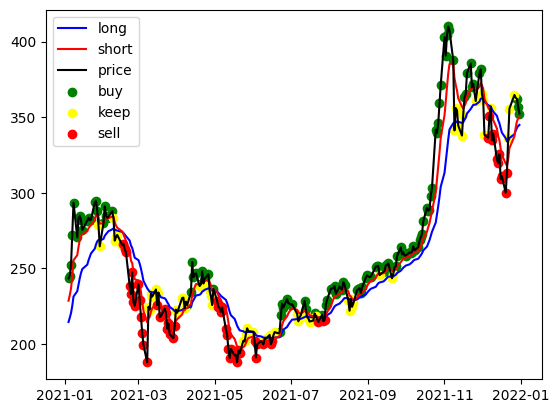

In [54]:
# Médias longa e curta
long_average = moving_average(tsla_data["Adj Close"], tsla_data["Date"], 21)
short_average = moving_average(tsla_data["Adj Close"], tsla_data["Date"], 8)
evaluations = ma_crossover(long_average, short_average)

# Datas de início e fim do intervalo do gráfico
start_date = "2021-01-01"
stop_date = "2022-01-01"

# Eventos de compra e venda do período
buys = evaluations[(evaluations.index > start_date) & (evaluations.index < stop_date) & (evaluations.values == 1)].index
keeps = evaluations[(evaluations.index > start_date) & (evaluations.index < stop_date) & (evaluations.values == 0)].index
sells = evaluations[(evaluations.index > start_date) & (evaluations.index < stop_date) & (evaluations.values == -1)].index

plt.plot(long_average[(long_average.index > pd.to_datetime(start_date)) & (long_average.index < pd.to_datetime(stop_date))], color = "blue", label = "long")
plt.plot(short_average[(short_average.index > pd.to_datetime(start_date)) & (short_average.index < pd.to_datetime(stop_date))], color = "red", label = "short")
plt.plot(pd.Series(tsla_data["Adj Close"][(tsla_data["Date"] > pd.to_datetime(start_date)) & (tsla_data["Date"] < pd.to_datetime(stop_date))].values, tsla_data["Date"][(tsla_data["Date"] > pd.to_datetime(start_date)) & (tsla_data["Date"] < pd.to_datetime(stop_date))]), color = "black", label = "price")
plt.scatter(buys, tsla_data[tsla_data["Date"].isin(buys)]["Adj Close"], color = "green", label = "buy")
plt.scatter(keeps, tsla_data[tsla_data["Date"].isin(keeps)]["Adj Close"], color = "yellow", label = "keep")
plt.scatter(sells, tsla_data[tsla_data["Date"].isin(sells)]["Adj Close"], color = "red", label = "sell")
plt.legend()